In [1]:
import astropy
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import Angle
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord
import astropy.units as un
from astropy.nddata import Cutout2D
import aplpy

import numpy as np

from matplotlib.patches import Ellipse, Rectangle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings("ignore");

In [2]:
def center(hdu):
    centpxl_ra, centpxl_dec = hdu.header['CRPIX1'], hdu.header['CRPIX2']
    center_ra, center_dec = hdu.header['CRVAL1'], hdu.header['CRVAL2']
    scale_ra, scale_dec = hdu.header['CDELT1'], hdu.header['CDELT2']
    npxl_ra, npxl_dec = hdu.header['NAXIS1'], hdu.header['NAXIS2']
    
    
    return centpxl_ra, centpxl_dec, center_ra, center_dec, scale_ra, scale_dec, npxl_ra, npxl_dec


def beam(hdu):
    b_major, b_minor, b_pa = hdu.header['BMAJ'], hdu.header['BMIN'], hdu.header['BPA']#*un.degree
    
    return b_major, b_minor, b_pa


def info(hdu):
    obs_code, obs_date = hdu.header['OBSERVER'], hdu.header['DATE-OBS']
    obsra, obsdec = hdu.header['OBSRA'], hdu.header['OBSDEC']
    rms, max, min = hdu.header['NOISE'], hdu.header['DATAMIN'], hdu.header['DATAMAX']
    
    return obs_code, obsra, obsdec, rms, max, min

def load(filename):
    #file = get_pkg_data_filename(filename)
    image = fits.open(filename)[0]
    array = image.data
    image_data = array[0][0]
    wcs= WCS(image.header)
    
    return(image_data, wcs, image)

def cut(data, wcs, hdu, center, box):
    size = un.Quantity(box, un.pix)
    cutout = Cutout2D(data, position=center, size=size, wcs=wcs)
    hdu.header.update(cutout.wcs.to_header())
    hdu.data = cutout.data
    wcs_cut = WCS(hdu.header)
    # wcs_cut_tmp2 = wcs_cut_tmp1.dropaxis(
    
    return(hdu.data,wcs_cut,hdu)

In [5]:
img_datad, wcsd, imaged = load('V1674HERIMG/V1674HERB_CLN.fits')
tmp = wcsd.dropaxis(3)
mywcsd = (tmp.dropaxis(2))

 
obsd, obsrad, obsdecd, rmsd, maxd, mind = info(imaged)
b_majord, b_minord, b_pad = beam(imaged)

centpxl_rad, centpxl_decd, center_rad, center_decd, scale_rad, scale_decd, npxl_rad, npxl_decd = center(imaged)

cut_datad, cut_wcsd, cut_hdud = cut(img_datad, mywcsd, imaged, center=(460,512), box=(300,300))

imaged.header

SIMPLE  =                    T           /Standard FITS file                    
BITPIX  =                  -32           /FITS data type                        
NAXIS   =                    2 / Dimensionality of array                        
NAXIS1  =                  300                                                  
NAXIS2  =                  300                                                  
EXTEND  =                    T           /Extensions may be present             
PCOUNT  =                    0           /Parameter count                       
GCOUNT  =                    1           /Group count                           
CTYPE1  = 'RA---SIN'           / Right ascension, orthographic/synthesis project
CRPIX1  =                202.0 / Pixel coordinate of reference point            
CRVAL1  = 284.37907083333            / [deg] Coordinate value at reference point
CDELT1  = -4.1666668951787E-08 / [deg] Coordinate increment at reference point  
CROTA1  =      0.00000000000

In [ ]:
steve = {};
steve = {'centpxl_rad': centpxl_rad}
steve["centpxl_rad"]

In [13]:
#imaged.header
#print(b_majord, b_minord)
b_conv = (3600)*(1e3)
pixscale = imaged.header['CDELT2']
beamsiz = b_majord*b_conv
#imaged.header
bsize = (3*beamsiz) / ( 3*pixscale*b_conv)
sbar_scale = 10/beamsiz


In [11]:
print(center_rad, center_decd)
maxb = 9.5325049187522e-05 
minb = -5.0190057663713e-05
wcsd#SkyCoord(ra=10.625*u.degree, dec=41.2*u.degree, frame='icrs')
mywcsd.world_to_pixel(SkyCoord(ra=284.37907083333*un.degree, dec=16.894302222222*un.degree, frame='fk5'))
#cut_wcsd[0,0].pixel_to_world_values(202,151)

284.37907083333 16.894302222222


(array(511.), array(512.00000034))

In [19]:
(b_majord *sbar_scale)

2.777777777777778e-06

Text(284.3790691666632, 16.89429659722169, '10 mas')

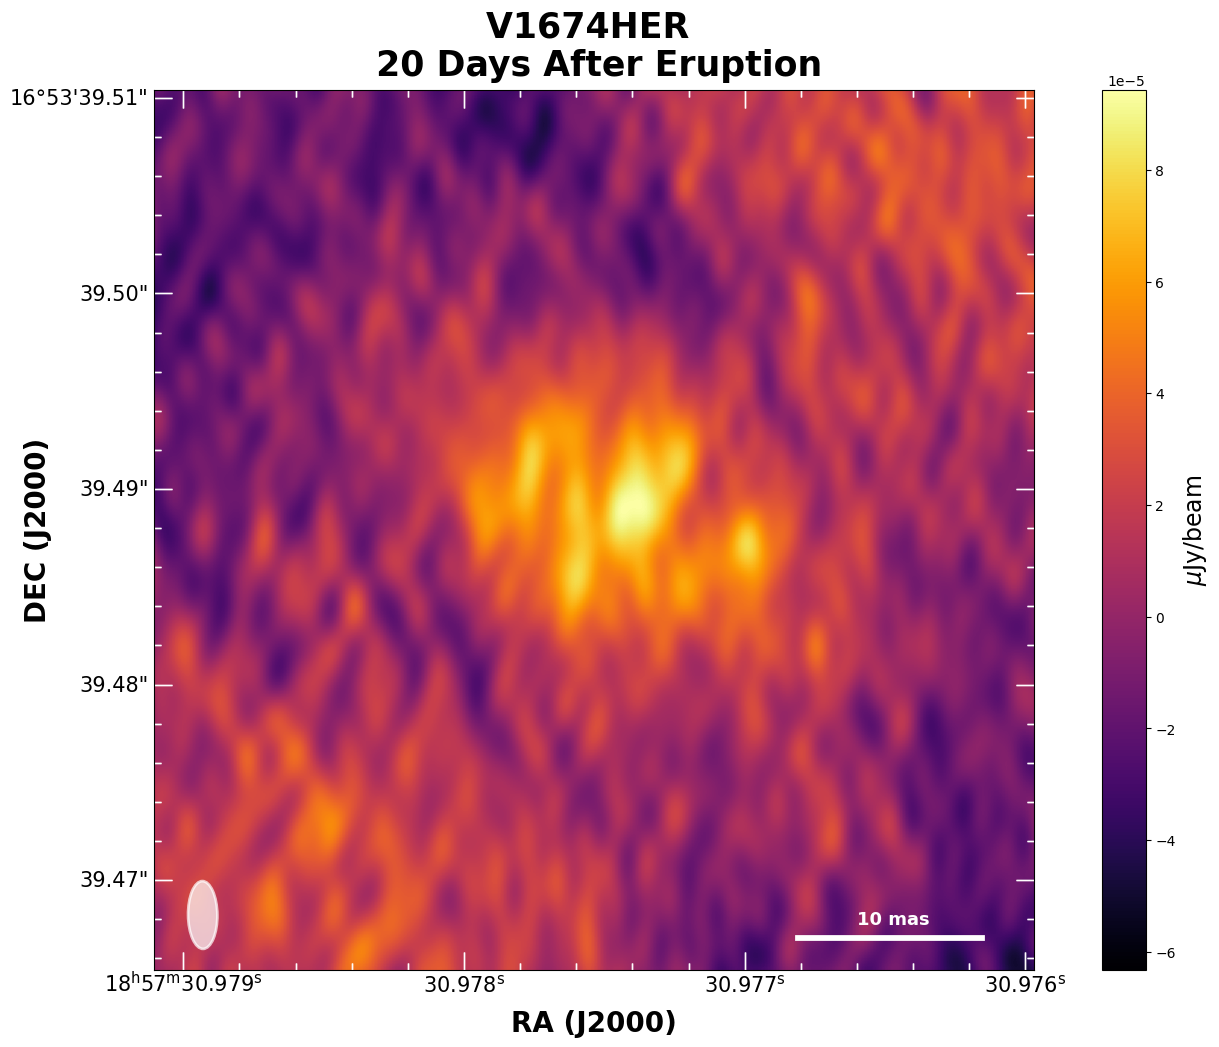

In [14]:
figd = plt.figure(figsize=(17,11))

axd = figd.add_axes([0.1, 0.1, 0.8, 0.8], projection=cut_wcsd, slices=('x','y',1,1))#, slices=('x', 'y',0, 0) #wcsb[3,4]


rad = axd.coords[0]
decd = axd.coords[1]

rad.set_axislabel('RA (J2000)', minpad=1, fontsize=20, weight='heavy');

decd.set_axislabel('DEC (J2000)', minpad=-1.0, fontsize=20, weight='heavy')

axd.set_title(f'V1674HER \n 20 Days After Eruption', fontsize=25,pad=10, weight='heavy')

decd.display_minor_ticks(True)
rad.display_minor_ticks(True)
axd.tick_params(which='both',direction='in',color='white',length=13,width=1,labelsize=15)
axd.tick_params(which='minor', length=5)




imd = axd.imshow(cut_datad, cmap='inferno', vmin=mind, vmax=maxd, transform=axd.get_transform(cut_wcsd[0,0]), origin='lower')
cbard = figd.colorbar(imd, location='right')
#fmt = matplotlib.ticker.FuncFormatter(func)

cbard.ax.set_ylabel(r'$\mu$Jy/beam', fontsize=17)
# for t in cbard.ax.get_yticklabels():
#     t.set_fontsize(8)
    
beam_rad  = center_rad - 170 *scale_rad + b_majord
beam_decd = center_decd - 155 *scale_decd + b_majord

sbar_rad = center_rad + 85 *scale_rad 
sbar_decd = center_decd - 140*scale_decd

sbartxt_rad = center_rad + 40 *scale_rad 
sbartxt_decd = center_decd - 135*scale_decd
sbar_text = '10 mas'

beam3d = Ellipse((beam_rad, beam_decd), height=b_majord, width=b_minord, angle=b_pad ,transform=axd.get_transform('fk5'),edgecolor='w', facecolor = 'w', alpha=0.7, lw=2)

scale = Rectangle((sbar_rad, sbar_decd), width = (b_majord *sbar_scale), height=(b_minord/10), transform= axd.get_transform('fk5'), 
                  color= 'w',edgecolor='w', facecolor = 'w', lw=2);

axd.add_patch(beam3d)
axd.add_patch(scale)
axd.text(sbartxt_rad, sbartxt_decd, sbar_text, transform=axd.get_transform('fk5'), color='w', weight='bold', fontsize=13)
#cut_hdud.writeto('./latest/07022021.fits')